# Cell Declustering with biased data using geostatspy

### Declustering techniques assign each datum a weight based on its closeness to surrounding data.The available data within a stationary domain zi,i=1,…,n are each assigned a weight wi,i=1,…,n based on the spatial proximity of the data. Data that are close get a reduced weight and data that are far apart get an increased weight. The premise being that closer data are more redundant and may preferentially sample low- or high-valued areas. A global non-parametric distribution or corrected categorical proportions are constructed using the weights and summary statistics also consider the weights. A representative distribution is useful for global resource assessment, checking estimated models and is required input to most simulation algorithms.The technique of cell declustering is robust and widely used. 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics

In [2]:
df=pd.read_csv(r"C:\Users\Hp\Downloads\sample_data_biased.csv")
df.head(10)

,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752
3,100,500,0,0.094414,1.609942
4,100,100,0,0.113049,10.886001
5,200,800,1,0.154648,106.491795
6,200,700,1,0.153113,140.976324
7,200,500,1,0.126167,12.548074
8,200,400,0,0.094750,1.208561
9,200,100,1,0.150961,44.687430


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,0.813149,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,207.832368,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566


## Specify the Area of Interest

It is natural to set the x and y coordinate and feature ranges manually. This will be our area of consideration. X and Y are coordinates in space. Also, let's pick a color map for display. Plasma is known to be friendly to the color blind as the color and intensity vary together. We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [4]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25;           # range of porosity values
cmap = plt.cm.inferno                   # color map

# 
Visualizing Tabular Data with Location Maps Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [6]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\geostatspy\GSLIB.py:257: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  im = plt.scatter(


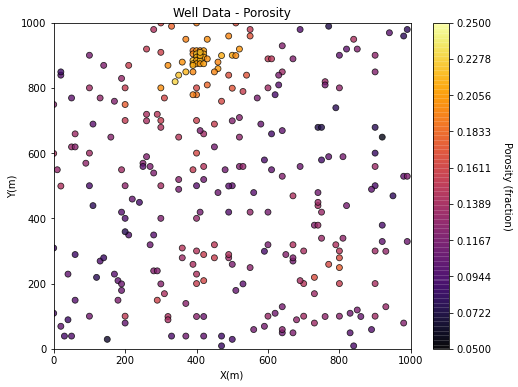

In [7]:
GSLIB.locmap(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap,'locmap_Porosity')

### Look carefully, and you'll notice the the spatial samples are more dense in the high porosity regions and lower in the low porosity regions. There is preferential sampling. We cannot use the naive statistics to represent this region. We have to correct for the clustering of the samples in the high porosity regions.

### Let's try cell declustering. We can interpret that we will want to minimize the declustering mean and that a cell size of between 100 - 200m is likely a good cell size, this is 'an ocular' estimate of the largest average spacing in the sparsely sampled regions.

#### Let's check out the declus program reimplimented from GSLIB.

In [8]:
GSLIB.declus

<function geostatspy.GSLIB.declus(df, xcol, ycol, vcol, cmin, cmax, cnum, bmin)>

## Description:Data are often spatially clustered; yet, we may need to have a histogram that is representative of the entire area of interest. To obtain a representative distribution, one approach is to assign declustering weights whereby values in areas/cells with more data receive less weight than those in sparsely sampled areas. The program declus provides an algorithm for determining 3-D declustering weights in cases where the clusters are known to be clustered preferentially in either high or low valued-areas. In other cases, polygon-type declustering weights might be considered whereby the weight is made proportional to the sample area (polygon) of influence.The declustering weights output by declusare standardized so that they sum to the number of data. A weight greater than 1.0 implies that the sample is being overweighted and a weight lesser than 1.0 implies that the sample is being downweighted (it is clustered with other samples).
o Parameters:
datafl: a data file in simplified Geo-EAS format containing the variable to be declustered.
icolx, icoly, icolz, and icolvr: the column numbers for the x y z coordinates and the variable.
tmin and tmax: all values strictly less than tmin and strictly greater than tmax are ignored.
sumfl: the output file containing all the attempted cell sizes and the associated declustered mean values.
outfl: file for PostScript output.
anisy and anisz: the anisotropy factors to consider rectangular cells. The cell size in the x direction is multiplied by these factors to get the cell size in the y and z directions, e.g., if a cell size of 10 is being considered and anisy2 and anisz3 then the cell size in the y direction is 20 and the cell size in the z direction is 30.
minmax: an integer flag that specifies whether a minimum mean value (minmax=0) or maximum mean value (minmax=1) is being looked for.
ncell, cmin, and cmax: the number of cell sizes to consider, the minimum size, and the maximum size. Note that these sizes apply directly to the x direction and the anis factors adjust the sizes in the y and z directions.
noff: the number of origin offsets. Each of the ncell cell sizes are considered with noff different original starting points. This avoids erratic results caused by extreme values falling into specific cells. A good number is 4 in 2-D and 8 in 3-D. A short description of the program

### We can now populate the parameters. The parameters are:

#### df - DataFrame with the spatial dataset
####  xcol - column with the x coordinate
#### ycol - column with the y coordinate
#### vcol - column with the feature value
#### iminmax - if 1 use the cell size that minimizes the declustered mean, if 0 the cell size that maximizes the declustered mean
#### noff - number of cell mesh offsets to average the declustered weights over
#### ncell - number of cell sizes to consider (between the cmin and cmax)
#### cmin - minimum cell size
#### cmax - maximum cell size

### We will run a very wide range of cell sizes, from 10m to 2,000m ('cmin' and 'cmax') and take the cell size that minimizes the declustered mean ('iminmax' = 1 minimize, and = 0 maximize). Multiple offsets (number of these is 'noff') uses multiple grid origins and averages the results to remove sensitivity to grid position. The ncell is the number of cell sizes.

### The output from this program is:

wts - an array with the weigths for each data (they sum to the number of data, 1 indicates nominal weight)
cell_sizes - an array with the considered cell sizes
dmeans - an array with the declustered mean for each of the cell_sizes
The wts are the declustering weights for the selected (minimizing or maximizing cell size) and the cell_sizes and dmeans are plotted to build the diagnostic declustered mean vs. cell size plot (see below).

In [10]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                            # add weights to the sample data DataFrame
df.head(20)                                  # preview to check the sample data DataFrame

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385207 


,X,Y,Facies,Porosity,Perm,Wts
0,100,900,1,0.115359,5.736104,3.064286
1,100,800,1,0.136425,17.211462,1.076608
2,100,600,1,0.135810,43.724752,0.997239
3,100,500,0,0.094414,1.609942,1.165119
4,100,100,0,0.113049,10.886001,1.224164
5,200,800,1,0.154648,106.491795,0.835969
6,200,700,1,0.153113,140.976324,0.714718
7,200,500,1,0.126167,12.548074,0.840038
8,200,400,0,0.094750,1.208561,0.888263
9,200,100,1,0.150961,44.687430,1.171910


c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\geostatspy\GSLIB.py:257: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  im = plt.scatter(


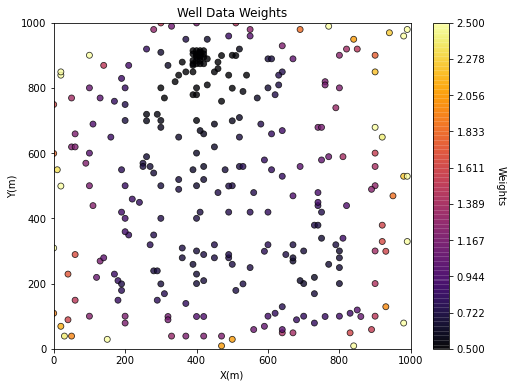

In [11]:
GSLIB.locmap(df,'X','Y','Wts',xmin,xmax,ymin,ymax,0.5,2.5,'Well Data Weights','X(m)','Y(m)','Weights',cmap,'locmap_Weights')

## It can be inferred that after declustering, the area of clustered samples nearly around x=400,y=900, it has been given least weights in order t minimize the biasness of the data.


### Does it look correct? See the weight varies with local sampling density?

### Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\geostatspy\GSLIB.py:323: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  im = plt.scatter(


Porosity naive mean is 0.135.
Porosity declustered mean is 0.121.
Correction of 0.1002.

Summary statistics of the declsutering weights:
DescribeResult(nobs=289, minmax=(0.2819756671865989, 3.984325446814365), mean=0.9999999999999996, variance=0.40927076480664726, skewness=1.9395015754905447, kurtosis=4.287460624778004)


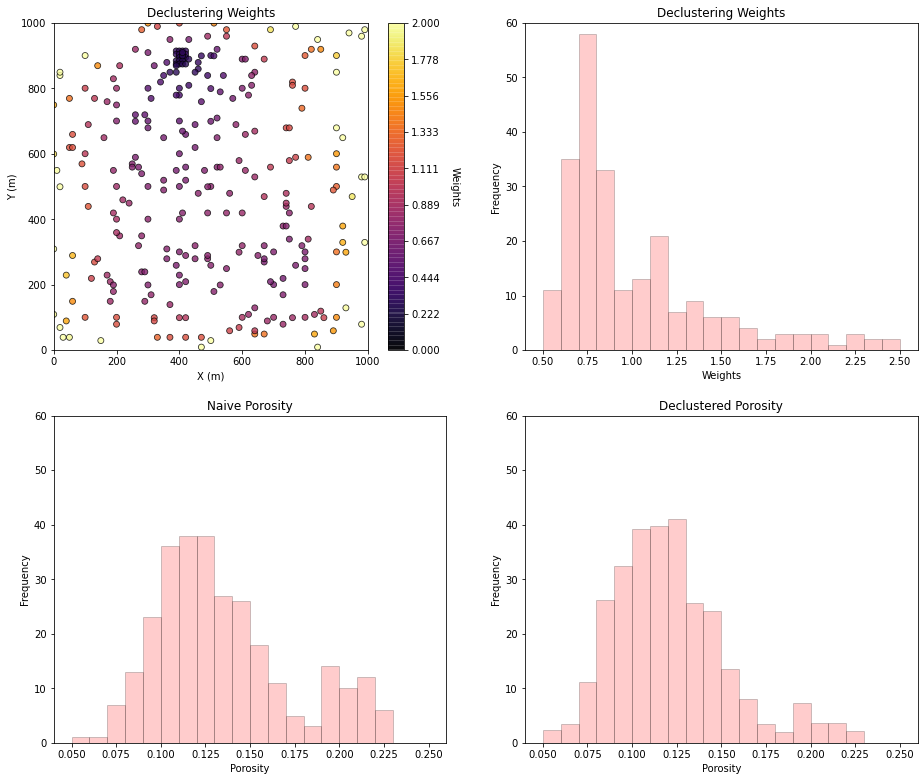

In [13]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts',xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(222)
GSLIB.hist_st(df['Wts'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Weights",title="Declustering Weights")
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts'],xlabel="Porosity",title="Declustered Porosity")
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean = np.average(df['Porosity'].values,weights=df['Wts'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity declustered mean is ' + str(round(por_dmean,3))+'.')
cor = (por_mean-por_dmean)/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the declsutering weights:')
print(stats.describe(wts))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Consider the declustered weights plot, the sparsely sampled area in location map have been given more weight as compared to densely populated samples. 

## Analysis of declustering cell size

#### Now let's look at the plot of the declustered porosity mean vs. the declustering cell size over the 100 runs. At very small and very large cell size the declustered mean is the naive mean.

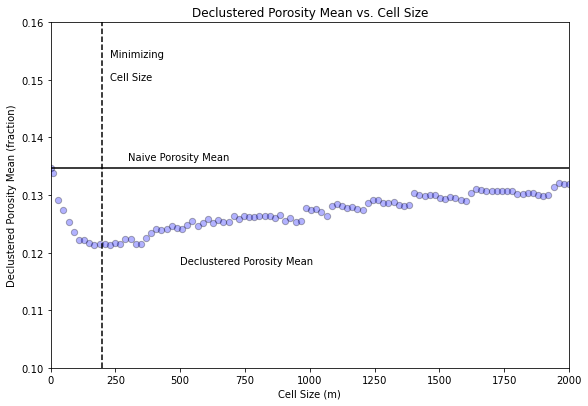

In [23]:
plt.subplot(111)
plt.scatter(cell_sizes, dmeans, s=40,c='blue', alpha = 0.3, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,2000],[por_mean,por_mean],color = 'black')
plt.plot([200,200],[0.10,0.16],color = 'black',linestyle='dashed')
plt.text(300., 0.136, r'Naive Porosity Mean')
plt.text(500., 0.118, r'Declustered Porosity Mean')
plt.text(230., 0.154, r'Minimizing')
plt.text(230., 0.150, r'Cell Size')
plt.ylim(0.10,0.16)
plt.xlim(0,2000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### The cell size that minimizes the declustered mean is about 200m (estimated from the figure).